# Introduction
Here we process the data from the electron microscopy 3D dataset, the first lines automatically download it if you have Kaggle setup otherwise you can download the dataset [here](https://www.epfl.ch/labs/cvlab/data/data-em/). The download link might be slow, in that case please log into Kaggle and download the data from here: https://www.kaggle.com/kmader/electron-microscopy-3d-segmentation

You need:
- Training sub volume
- Ground truth sub volume

Save the images in the sub folder "input".

In [22]:
import os
if not os.path.exists('input'):
    !curl -L -o input/electron-microscopy-3d-segmentation.zip https://www.kaggle.com/api/v1/datasets/download/kmader/electron-microscopy-3d-segmentation
    !unzip input/electron-microscopy-3d-segmentation.zip -d input


In [23]:
import matplotlib.patches as mpatches  # for showing rectangles and annotations
from skimage.color import label2rgb  # for making overlay plots
import numpy as np  # for matrix operations and array support
from skimage.measure import regionprops  # for shape analysis
from skimage.measure import label  # for labeling regions
import matplotlib.pyplot as plt  # for showing plots
from skimage.io import imread  # for reading images
from scipy import ndimage
from skimage.morphology import medial_axis
from skimage.segmentation import watershed
create_dist_map = lambda img, mask=None: medial_axis(img,mask, return_distance = True)[1]
plt_settings = {'interpolation':'none'}
%matplotlib inline

# Connected Component Labeling
scikit-image has basic support for [connected component labeling](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.label) and we can do some small demos with the label function and small test images, before moving onto bigger datasets. 

## Neighborhood
In the course we use the term neighborhood and here we use the term ```connectivity``` for the same idea. 

 - For a 2D image a connectivity = 1 is just the 4-neighborhood (or pixels that share an edge, connectivity = 2 is then 8-neighborhood (or pixels that share a vertex).

In [26]:
# simple test image diagonal
test_img = np.eye(4)
print('Input Image')
print(test_img)

test_label_4 = label(test_img, connectivity=1)
print('Labels with 4-neighborhood')
print(test_label_4)

test_label_8 = label(test_img, connectivity=2)
print('Labels with 8-neighborhood')
print(test_label_8)

Input Image
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Labels with 4-neighborhood
[[1 0 0 0]
 [0 2 0 0]
 [0 0 3 0]
 [0 0 0 4]]
Labels with 8-neighborhood
[[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]


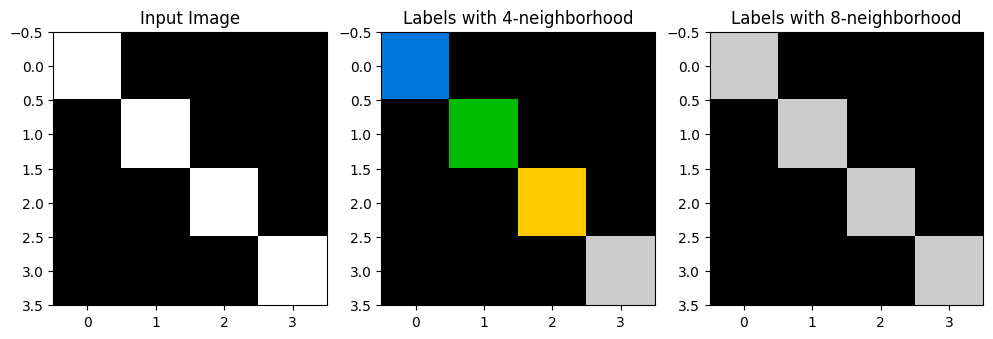

In [27]:
# Plot the images
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
im1 = ax[0].imshow(test_img.astype(int), cmap='gray')
ax[0].set_title('Input Image')
im2 = ax[1].imshow(test_label_4, cmap='nipy_spectral')
ax[1].set_title('Labels with 4-neighborhood')
im3 = ax[2].imshow(test_label_8, cmap='nipy_spectral')
ax[2].set_title('Labels with 8-neighborhood')

plt.show()


## 3D Neighborhood

For a 3D image a connectivity = 1 is just the 6-neighborhood (or voxels that share an face, connectivity = 2 is then voxels that share an edge and 3 is voxels that share a vertex

In [28]:
test_img = np.array(
    [1 if x in [0, 13, 26] else 0 for x in range(27)]).reshape((3, 3, 3))
print('Input Image')
print(test_img)

test_label_1 = label(test_img, connectivity=1)
print('Labels with Face-sharing')
print(test_label_1)

test_label_2 = label(test_img, connectivity=2)
print('Labels with Edge-Sharing')
print(test_label_2)

test_label_3 = label(test_img, connectivity=3)
print('Labels with Vertex-Sharing')
print(test_label_3)

Input Image
[[[1 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 1 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 1]]]
Labels with Face-sharing
[[[1 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 2 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 3]]]
Labels with Edge-Sharing
[[[1 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 2 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 3]]]
Labels with Vertex-Sharing
[[[1 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 1 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 1]]]


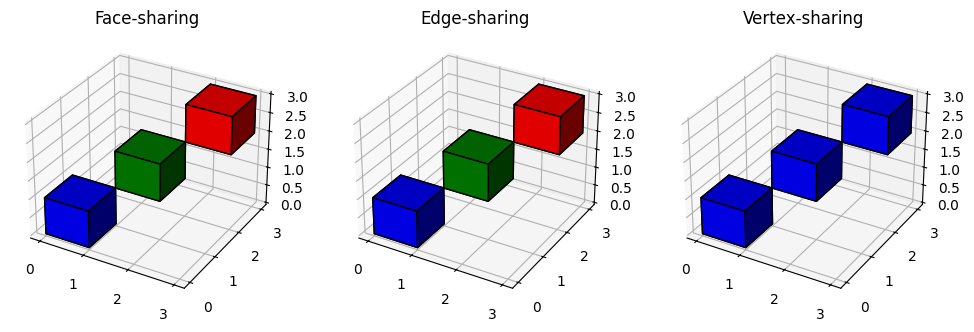

In [29]:
# Plot the 3 volumes in 3D
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

# Function to generate colors based on voxel values
def generate_colors(volume):
    colors = np.empty(volume.shape, dtype=object)
    for i in range(volume.shape[0]):
        for j in range(volume.shape[1]):
            for k in range(volume.shape[2]):
                value = volume[i, j, k]
                if value == 0:
                    colors[i, j, k] = 'white'
                elif value == 1:
                    colors[i, j, k] = 'blue'
                elif value == 2:
                    colors[i, j, k] = 'green'
                elif value == 3:
                    colors[i, j, k] = 'red'
                # Add more conditions for other values if needed
    return colors

# Plot the 3D volumes with different colors for each voxel
colors1 = generate_colors(test_label_1)
colors2 = generate_colors(test_label_2)
colors3 = generate_colors(test_label_3)

ax1.voxels(test_label_1, edgecolor='k', facecolors=colors1)
ax1.set_title('Face-sharing')
ax2.voxels(test_label_2, edgecolor='k', facecolors=colors2)
ax2.set_title('Edge-sharing')
ax3.voxels(test_label_3, edgecolor='k', facecolors=colors3)
ax3.set_title('Vertex-sharing')

plt.show()

In [30]:
def imread_or_invent(in_path):
    np.random.seed(2018)
    if os.path.exists(in_path):
        return imread(in_path)
    else:
        print('Getting creative...')
        fake_shape = (10, 50, 75)
        if 'groundtruth' in in_path:
            return (np.random.uniform(0, 1, size=fake_shape) > 0.99).astype(int)
        else:
            return np.random.uniform(0, 1, size=fake_shape)


em_image_vol = imread_or_invent('input/training.tif')
em_thresh_vol = imread_or_invent('input/training_groundtruth.tif')
print("Data Loaded, Dimensions", em_image_vol.shape, '->', em_thresh_vol.shape)

Data Loaded, Dimensions (165, 768, 1024) -> (165, 768, 1024)


# 2D Analysis
Here we work with a single 2D slice to get started and take it randomly from the middle

In [31]:
em_idx = np.random.permutation(range(em_image_vol.shape[0]))[0]
em_slice = em_image_vol[em_idx]
em_thresh = em_thresh_vol[em_idx]
print("Slice Loaded, Dimensions", em_slice.shape)

Slice Loaded, Dimensions (768, 1024)


Text(0.5, 1.0, 'Overlayed')

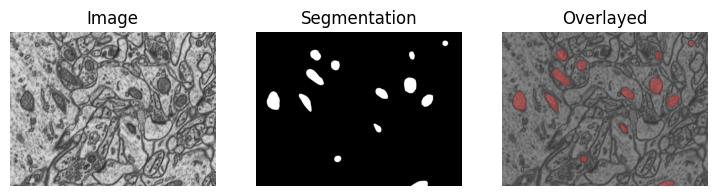

In [32]:
# show the slice and threshold
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 4))
ax1.imshow(em_slice, cmap='gray')
ax1.axis('off')
ax1.set_title('Image')
ax2.imshow(em_thresh, cmap='gray')
ax2.axis('off')
ax2.set_title('Segmentation')
# here we mark the threshold on the original image

ax3.imshow(label2rgb(em_thresh, em_slice, bg_label=0))
ax3.axis('off')
ax3.set_title('Overlayed')

13 number of labels


Text(0.5, 1.0, 'Overlayed')

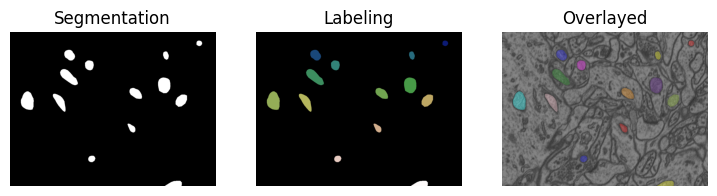

In [33]:
# make connected component labels
em_label = label(em_thresh)
print(em_label.max(), 'number of labels')
# show the segmentation, labels and overlay
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 4))
ax1.imshow(em_thresh, cmap='gray')
ax1.axis('off')
ax1.set_title('Segmentation')
ax2.imshow(em_label, cmap=plt.cm.gist_earth)
ax2.axis('off')
ax2.set_title('Labeling')
# here we mark the threshold on the original image

ax3.imshow(label2rgb(em_label, em_slice, bg_label=0))
ax3.axis('off')
ax3.set_title('Overlayed')

# Shape Analysis 
For shape analysis we use the regionprops function which calculates the area, perimeter, and other features for a shape. The analysis creates a list of these with one for each label in the original image.

In [35]:
shape_analysis_list = regionprops(em_label)
first_region = shape_analysis_list[0]
print('List of region properties for', len(shape_analysis_list), 'regions')
print('Features Calculated:', ', '.join(
    [f for f in dir(first_region) if not f.startswith('_')]))

List of region properties for 13 regions
Features Calculated: area, area_bbox, area_convex, area_filled, axis_major_length, axis_minor_length, bbox, centroid, centroid_local, centroid_weighted, centroid_weighted_local, coords, coords_scaled, eccentricity, equivalent_diameter_area, euler_number, extent, feret_diameter_max, image, image_convex, image_filled, image_intensity, inertia_tensor, inertia_tensor_eigvals, intensity_max, intensity_mean, intensity_min, intensity_std, label, moments, moments_central, moments_hu, moments_normalized, moments_weighted, moments_weighted_central, moments_weighted_hu, moments_weighted_normalized, num_pixels, orientation, perimeter, perimeter_crofton, slice, solidity


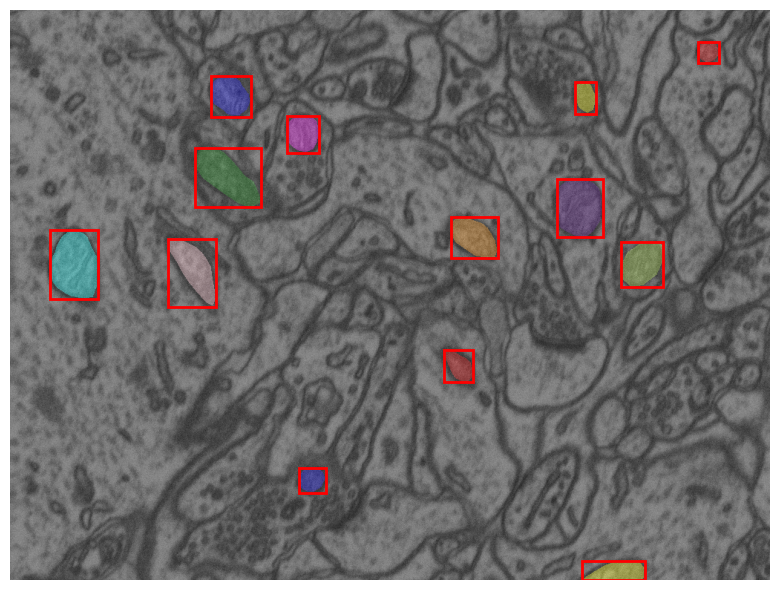

In [36]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(label2rgb(em_label, em_slice, bg_label=0))

for region in shape_analysis_list:
    # draw rectangle using the bounding box
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()

## Anisotropy
We can calculate anisotropy as we did in the course by using the largest and shortest lengths, called here as ```major_axis_length``` and ```minor_axis_length``` respectively

- Try using different formulas for anisotropy to see how it changes what is shown

$$ Aiso1 = \frac{\text{Longest Side}}{\text{Shortest Side}} - 1 $$

$$ Aiso2 = \frac{\text{Longest Side}-\text{Shortest Side}}{\text{Longest Side}} $$

$$ Aiso3 = \frac{\text{Longest Side}}{\text{Average Side Length}} - 1 $$

$$ Aiso4 = \frac{\text{Longest Side}-\text{Shortest Side}}{\text{Average Side Length}} $$

Label: 1 Anisotropy 0.05
Label: 2 Anisotropy 0.30
Label: 3 Anisotropy 0.56
Label: 4 Anisotropy 0.14
Label: 5 Anisotropy 1.53
Label: 6 Anisotropy 0.26
Label: 7 Anisotropy 0.75
Label: 8 Anisotropy 0.46
Label: 9 Anisotropy 1.75
Label: 10 Anisotropy 0.47
Label: 11 Anisotropy 0.93
Label: 12 Anisotropy 0.13
Label: 13 Anisotropy 2.02


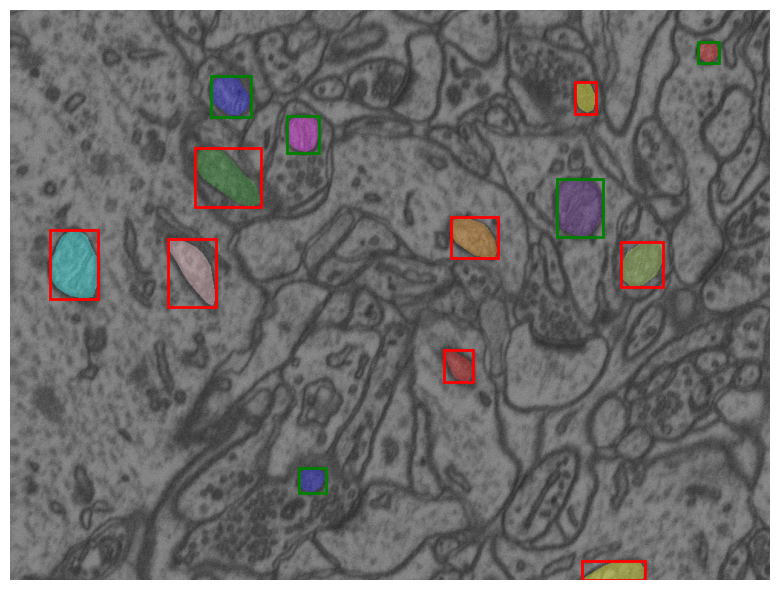

In [37]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(label2rgb(em_label, em_slice, bg_label=0))

for region in shape_analysis_list:
    x1 = region.major_axis_length
    x2 = region.minor_axis_length
    anisotropy = x1/x2 -1 if x2 > 0 else 0
    # anisotropy = (x1-x2)/np.clip((x1+x2)/2, 0.1, 9999)
    # for anisotropic shapes use red for the others use blue
    print('Label:', region.label, 'Anisotropy %2.2f' % anisotropy)
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                fill=False, edgecolor='red' if anisotropy > 0.3 else 'green', linewidth=2)
    ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()

# Distance Maps
Here we calculate distance maps with the ```ndimage.distance_transform_``` family of functions. Initially we focus on test images since it is easier to see what is happening with these images.

In [38]:
def generate_dot_image(size = 100, cutoff = 0.15):
    """
    Create a simple  synthetic image with a repeating pattern
    Keyword arguments:
    size -- the size of the image on one size, final size is size x size (default 100)
    imag -- the cutoff between 0 and 1, higher means less connected objects (default 0.15)
    """
    xx,yy = np.meshgrid(range(size),range(size))
    return np.sin(6*np.pi*xx/(100)-1)+1.25*np.cos(5*np.pi*yy/(100)-2)>cutoff

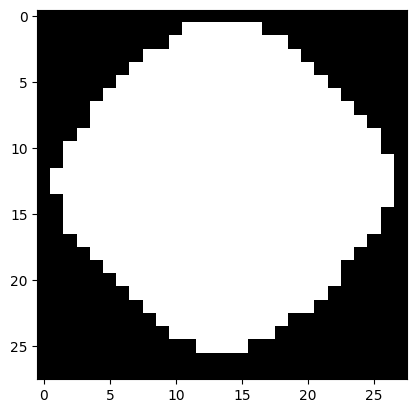

In [39]:
%matplotlib inline
img_bw = generate_dot_image(28,0.50)
plt.imshow(img_bw,cmap='gray', **plt_settings)

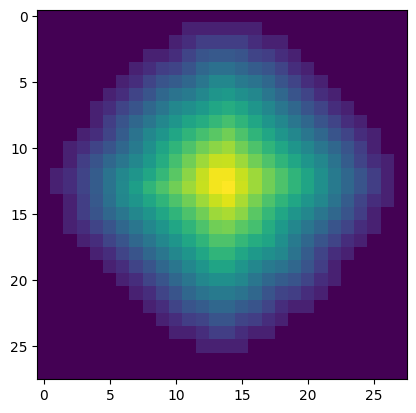

In [40]:
%matplotlib inline
img_dist = ndimage.distance_transform_edt(img_bw)
plt.imshow(img_dist, **plt_settings)


## Comparing 
There are a number of different methods for ```distance_transform``` inside the ```ndimage``` package of ```scipy``` compare the results of the different approaches for this and other images.
- What are the main differences?
- Quantitatively (histogram) show what situations each one might be best suited for?

Text(0.5, 1.0, 'Distance\n(px)')

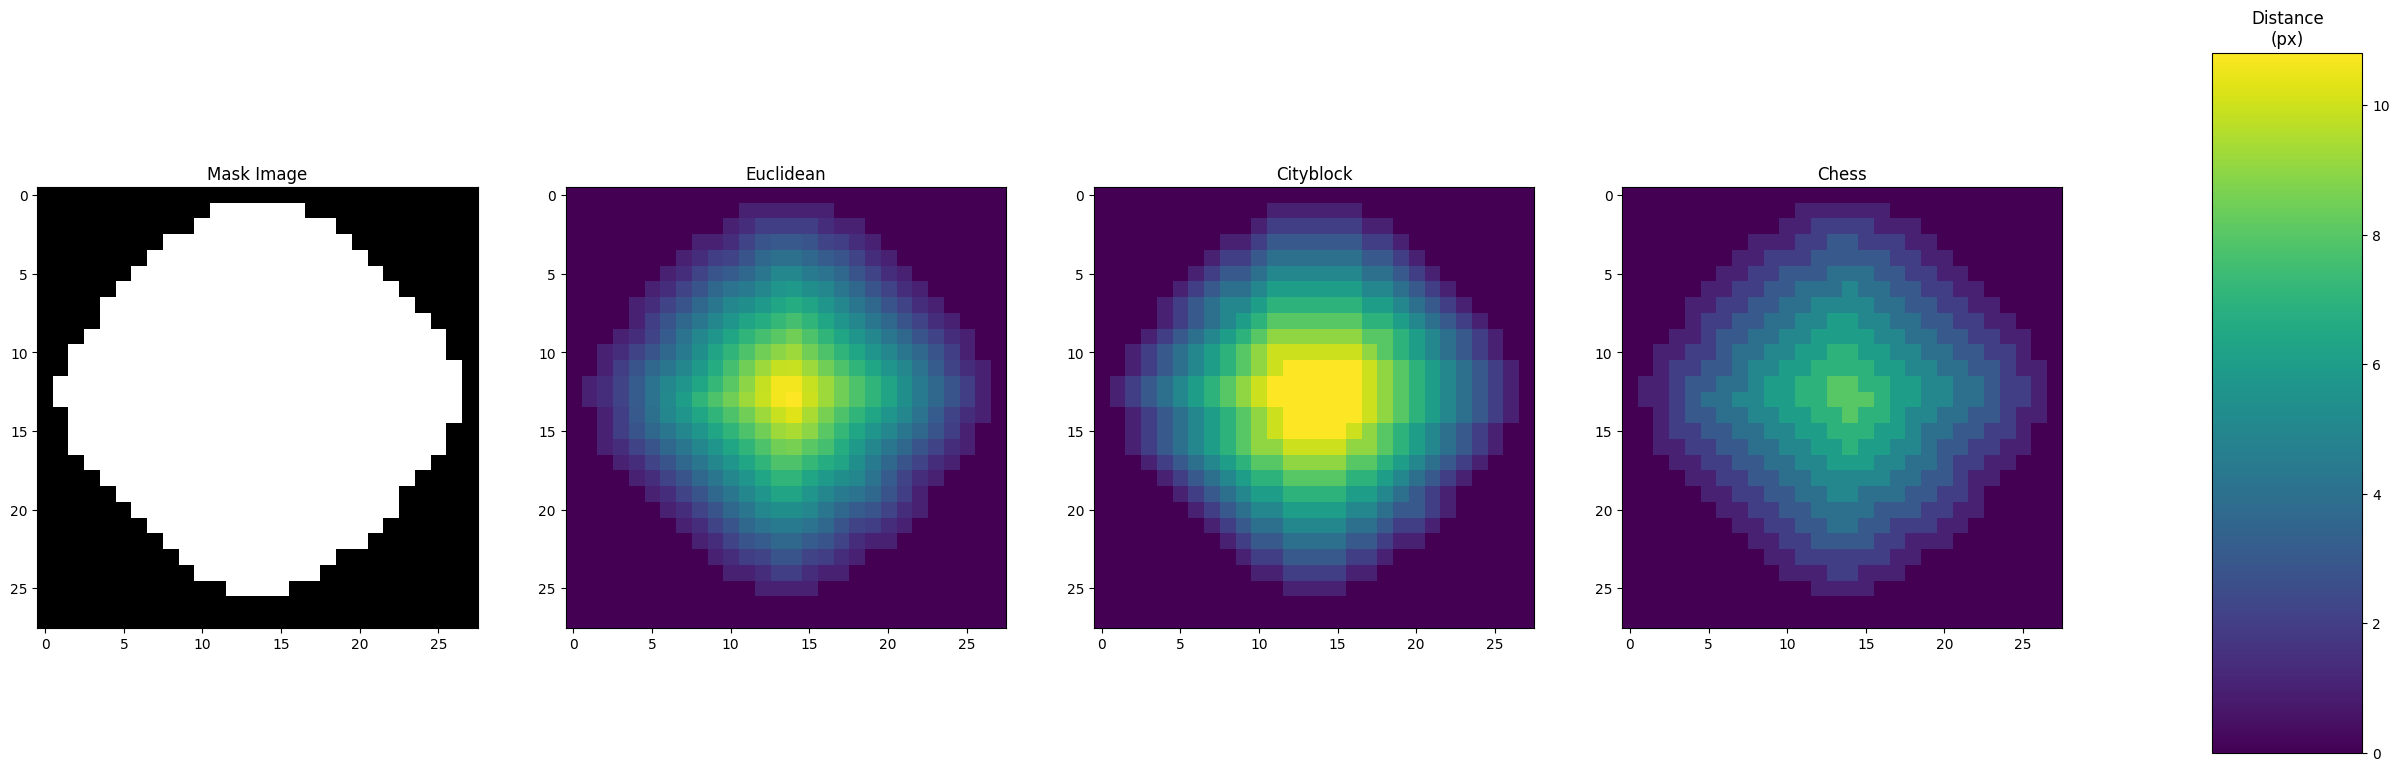

In [41]:
%matplotlib inline
# calculate new distance transforms
img_dist = ndimage.distance_transform_edt(img_bw)
img_dist_cityblock = ndimage.distance_transform_cdt(img_bw,metric = 'taxicab')
img_dist_chess = ndimage.distance_transform_cdt(img_bw,metric = 'chessboard')

fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize = (30,10))
ax1.imshow(img_bw,cmap = 'gray', **plt_settings)
ax1.set_title('Mask Image')
dmap_im = ax2.imshow(img_dist,vmax = img_dist.max(), **plt_settings)
ax2.set_title('Euclidean')
ax3.imshow(img_dist_cityblock,vmax = img_dist.max(), **plt_settings)
ax3.set_title('Cityblock')
ax4.imshow(img_dist_chess,vmax = img_dist.max(), **plt_settings)
ax4.set_title('Chess')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(dmap_im,cax=cbar_ax)
cbar_ax.set_title('Distance\n(px)')


1. **Euclidean Distance Transform (EDT)**
$$
d_E(p) = \min_{q \in S} \| p - q \|_2
$$
where:
$$
\| p - q \|_2 = \sqrt{(x_p - x_q)^2 + (y_p - y_q)^2}
$$

2. **City Block (Manhattan) Distance Transform (CDT, Taxicab metric)**
$$
d_{M}(p) = \min_{q \in S} \| p - q \|_1
$$
where:
$$
\| p - q \|_1 = |x_p - x_q| + |y_p - y_q|
$$

3. **Chessboard Distance Transform (CDT, Chessboard metric)**
$$
d_C(p) = \min_{q \in S} \| p - q \|_{\infty}
$$
where:
$$
\| p - q \|_{\infty} = \max(|x_p - x_q|, |y_p - y_q|)
$$


## More Complicated Objects
We now make the image bigger (changing the ```size``` parameter) and connect them together (the ```cutoff``` parameter)

Text(0.5, 1.0, 'Distance\n(px)')

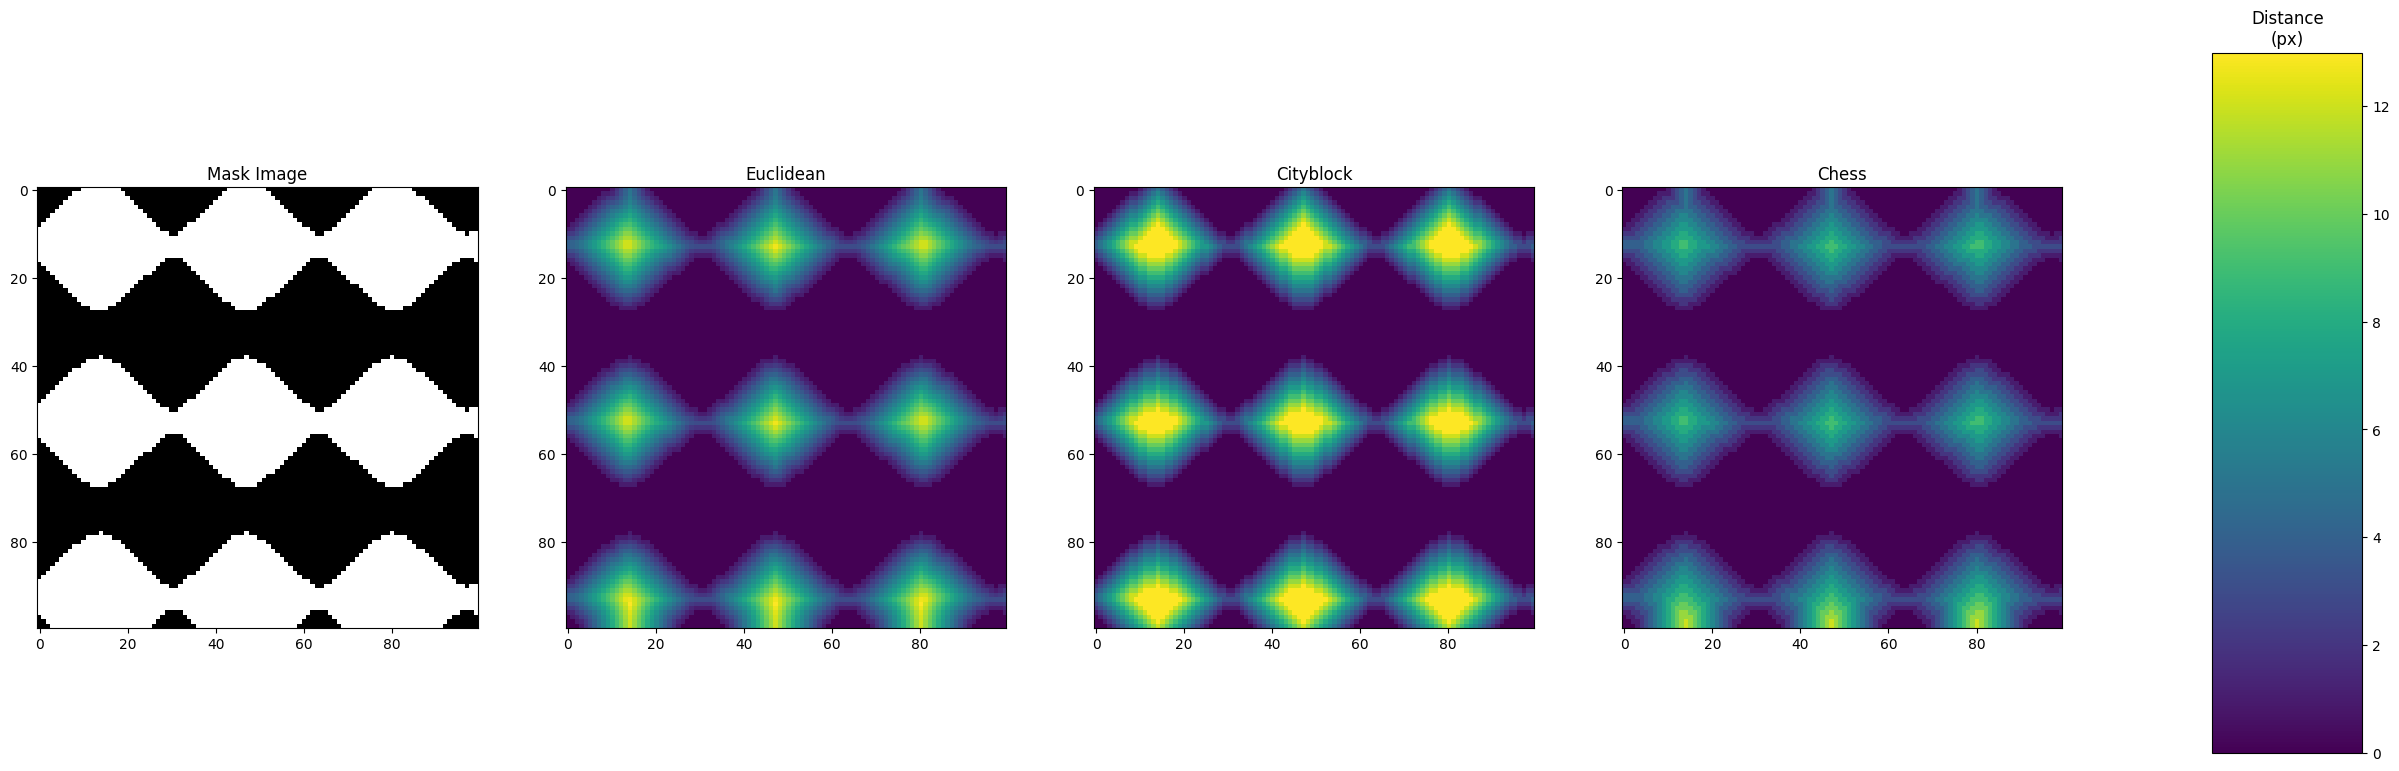

In [42]:
%matplotlib inline
# use a bigger base image
img_bw = generate_dot_image(100,0.15)
img_dist = ndimage.distance_transform_edt(img_bw)
img_dist_cityblock = ndimage.distance_transform_cdt(img_bw,metric = 'taxicab')
img_dist_chess = ndimage.distance_transform_cdt(img_bw,metric = 'chessboard')

fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize = (30,10))
ax1.imshow(img_bw,cmap = 'gray', **plt_settings)
ax1.set_title('Mask Image')
dmap_im = ax2.imshow(img_dist,vmax = img_dist.max(), **plt_settings)
ax2.set_title('Euclidean')
ax3.imshow(img_dist_cityblock,vmax = img_dist.max(), **plt_settings)
ax3.set_title('Cityblock')
ax4.imshow(img_dist_chess,vmax = img_dist.max(), **plt_settings)
ax4.set_title('Chess')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(dmap_im,cax=cbar_ax)
cbar_ax.set_title('Distance\n(px)')


# Watershed
We can use the watershed transform to segment closely connected objects. We see in the first image that the standard connected component labeling ```ndimage.label``` shows only 3 when we see 9

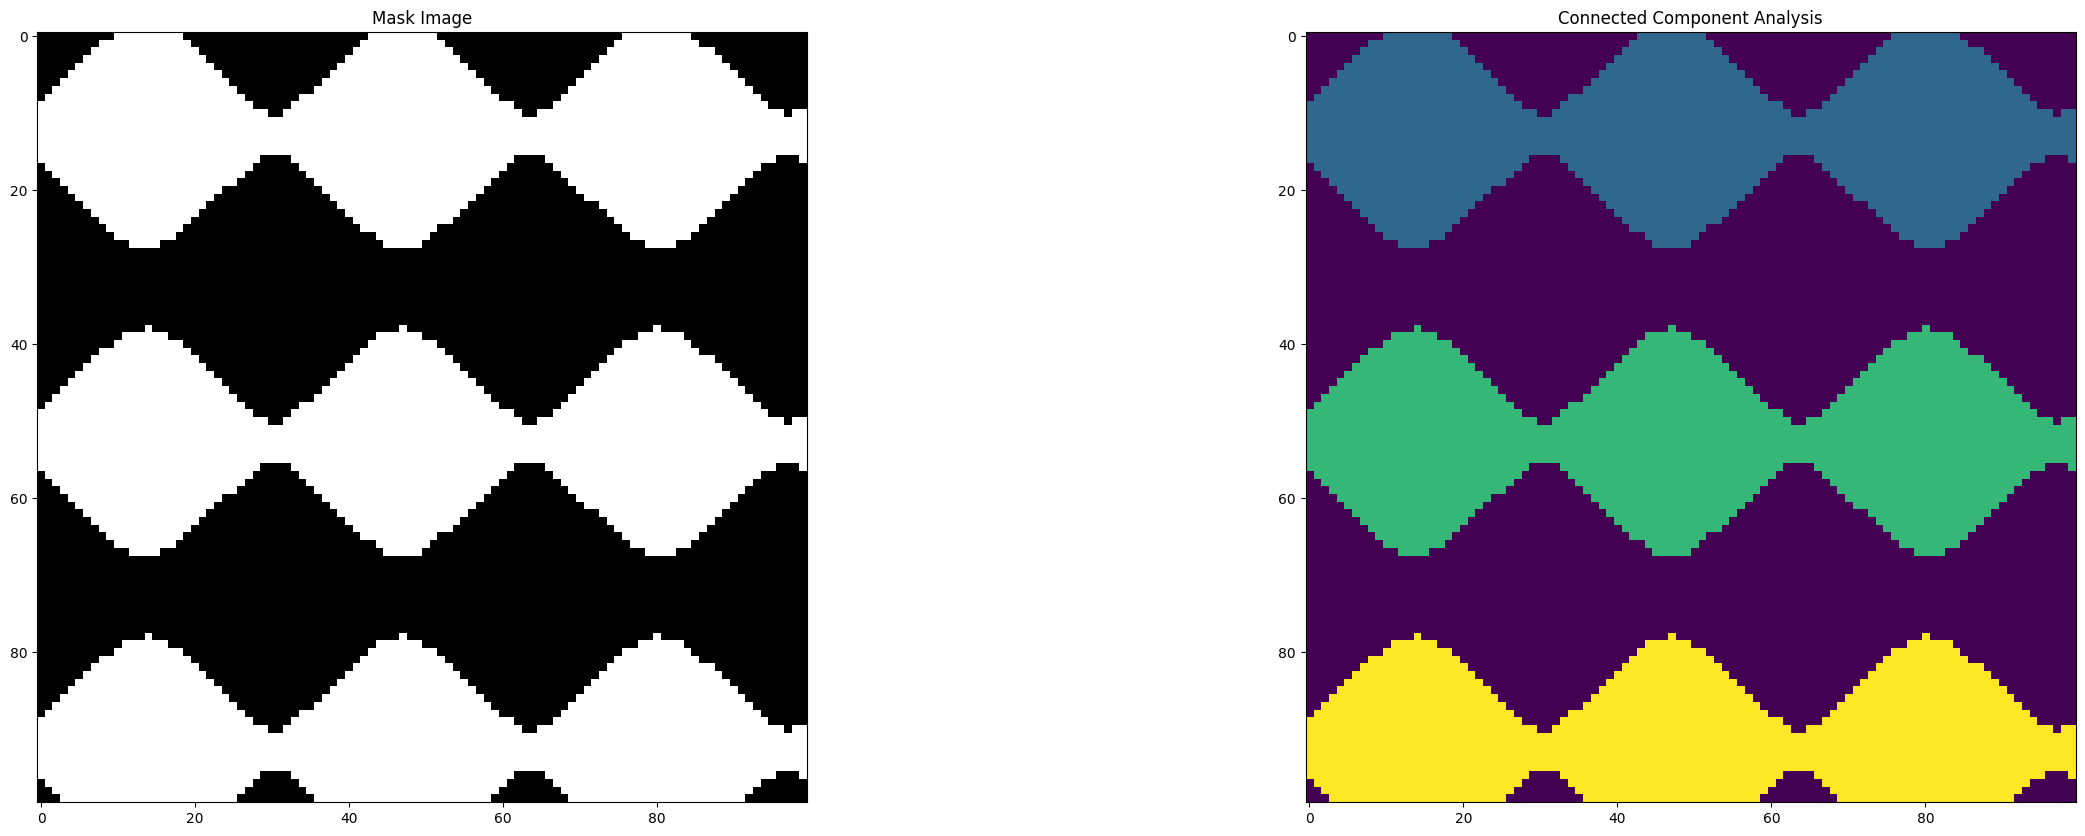

In [43]:
cc_img = ndimage.label(img_bw)[0]

%matplotlib inline
fig, (ax1,ax2) = plt.subplots(1,2, figsize = (30,10))
ax1.imshow(img_bw,cmap = 'gray', **plt_settings)
ax1.set_title('Mask Image')
dmap_im = ax2.imshow(cc_img, **plt_settings)
ax2.set_title('Connected Component Analysis');

In [44]:
from skimage.feature import peak_local_max
def simple_watershed(img_dist, img_bw):
    """
    Calculate the watershed transform on an image and its distance map 
    by finding the troughs and expanding from these points.
    """
    # Find local maxima
    local_maxi_coords = peak_local_max(img_dist, labels=img_bw, footprint=np.ones((9, 9)))

    # Create image from the local maxima
    local_maxi = np.zeros(img_dist.shape, dtype=bool)
    local_maxi[local_maxi_coords[:, 0], local_maxi_coords[:, 1]] = True

    # Label the maxima
    markers = ndimage.label(local_maxi)[0]

    return watershed(-img_dist, markers, mask=img_bw)

## Applying Watershed
We can apply watershed to the following image. 
- Why do the bottom row of objects not show up?
- How can the results be improved

Text(0.5, 1.0, 'Watershed Analysis')

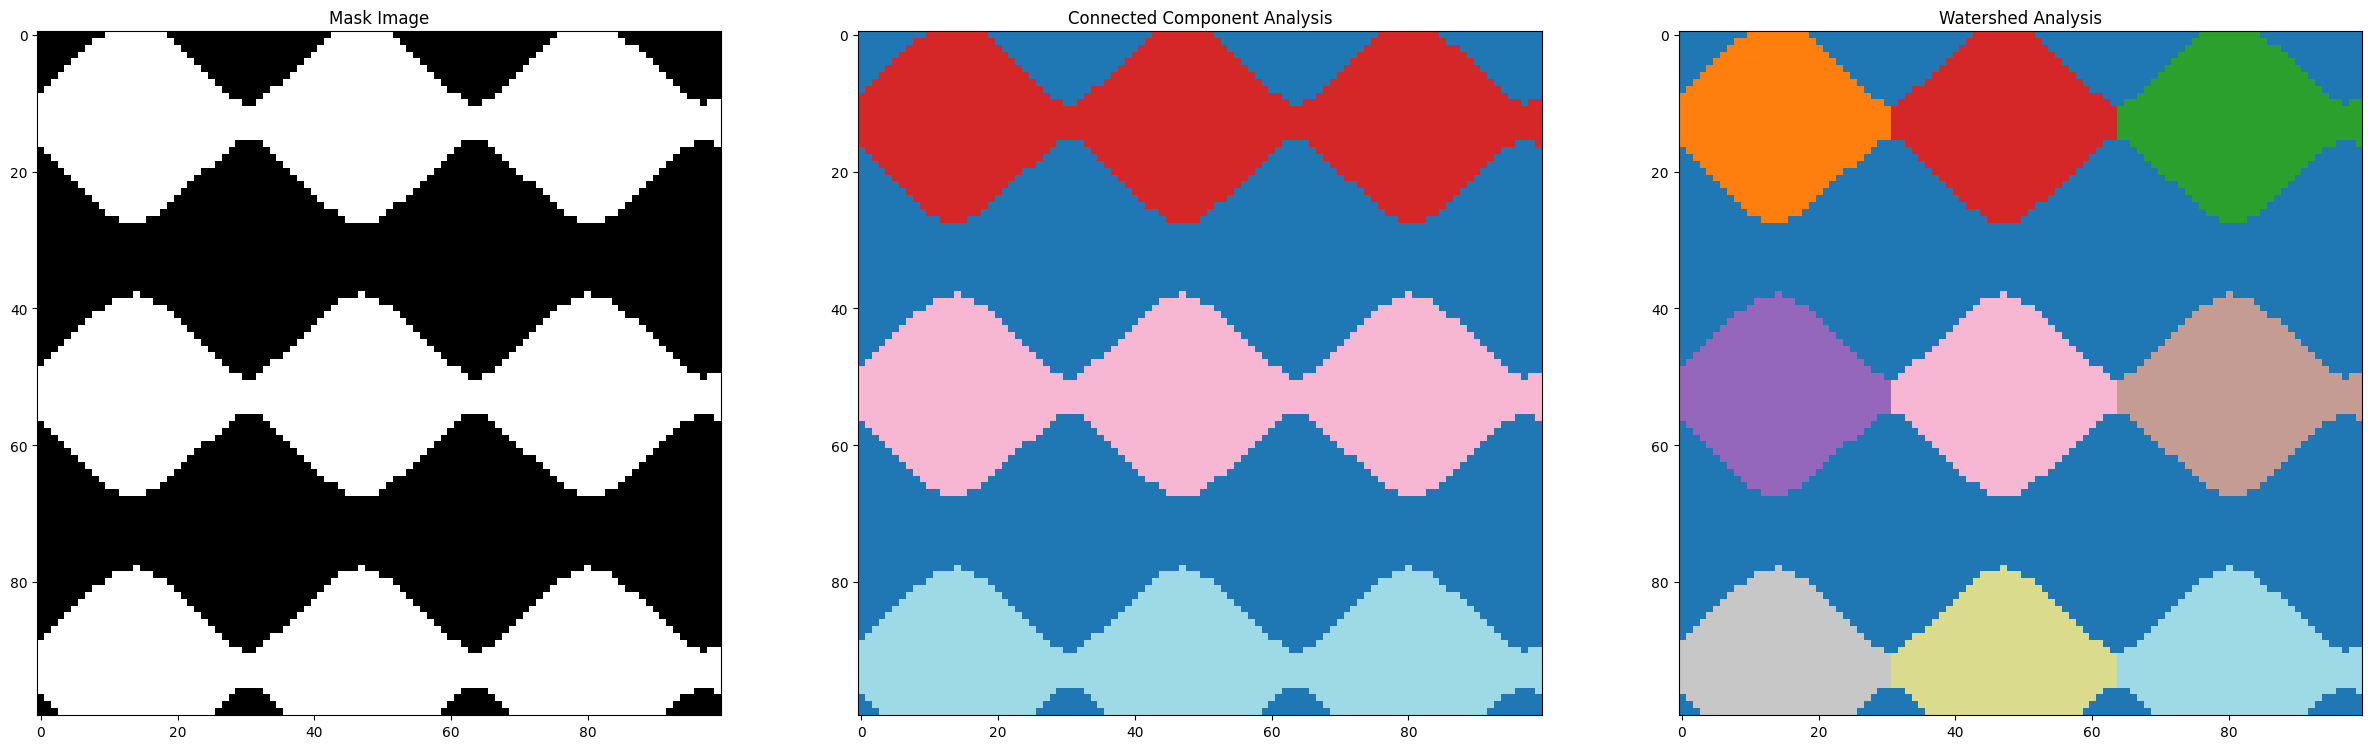

In [45]:
ws_img = simple_watershed(img_dist,img_bw)
%matplotlib inline
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize = (30,10))
ax1.imshow(img_bw,cmap = 'gray', **plt_settings)
ax1.set_title('Mask Image')
ax2.imshow(cc_img, cmap="tab20",**plt_settings)
ax2.set_title('Connected Component Analysis')
ax3.imshow(ws_img, cmap="tab20",**plt_settings)
ax3.set_title('Watershed Analysis')